# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).

def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

filtered_data.head(3)

Number of data points in our data (50000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [23]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in final['Summary'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [97]:
# Initializing count vect
count_vect = CountVectorizer(min_df=5) #in scikit-learn
bow_data = count_vect.fit_transform(preprocessed_reviews)
bow_data.shape

(46071, 12157)

In [98]:
# Performing K-means clustering
from sklearn.cluster import KMeans

clusters = [2,4,6,8,10,12,14]
inertia = [] # To measure squared distance of sample from nearest cluster distance.

for i in clusters:
    kmean = KMeans(n_clusters=i)
    kmean = kmean.fit(bow_data)
    inertia.append(kmean.inertia_)

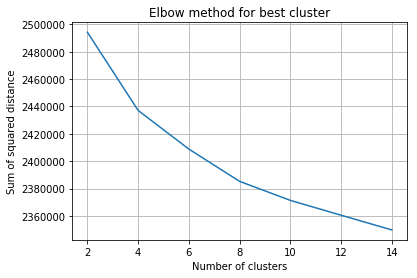

In [99]:
import matplotlib.pyplot as plt

plt.plot(clusters,inertia)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.grid()
plt.title("Elbow method for best cluster")
plt.show()

In [100]:
# Taking optimal k=4 as after that graph falls slowly
k=4
kmean = KMeans(n_clusters=k).fit(bow_data)
print(len(kmean.labels_))

46071


In [101]:
kmean.labels_

array([0, 0, 0, ..., 0, 3, 0], dtype=int32)

In [102]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
cluster1 = [] 
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(len(kmean.labels_)):
    if(kmean.labels_[i]==0):
        cluster1.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==1):
        cluster2.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==2):
        cluster3.append(preprocessed_reviews[i])
    else:
        cluster4.append(preprocessed_reviews[i])
        

In [103]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(cluster1)))
print("Length of cluster {} is {}".format(2,len(cluster2)))
print("Length of cluster {} is {}".format(3,len(cluster3)))
print("Length of cluster {} is {}".format(4,len(cluster4)))

Length of cluster 1 is 30919
Length of cluster 2 is 2008
Length of cluster 3 is 1221
Length of cluster 4 is 13144


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [116]:
from wordcloud import WordCloud
def plot_wordcloud(reviews):
    wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                min_font_size = 10).generate(reviews) 
  
    return wordcloud

In [117]:
# For cluster1
reviews1 = ''
for sent in cluster1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in cluster2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in cluster3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)

# For cluster4
reviews4 = ''
for sent in cluster4:
    wrds = sent.split()
    for wrd in wrds:
        reviews4 += wrd + ' '
wordcloud4 = plot_wordcloud(reviews4)

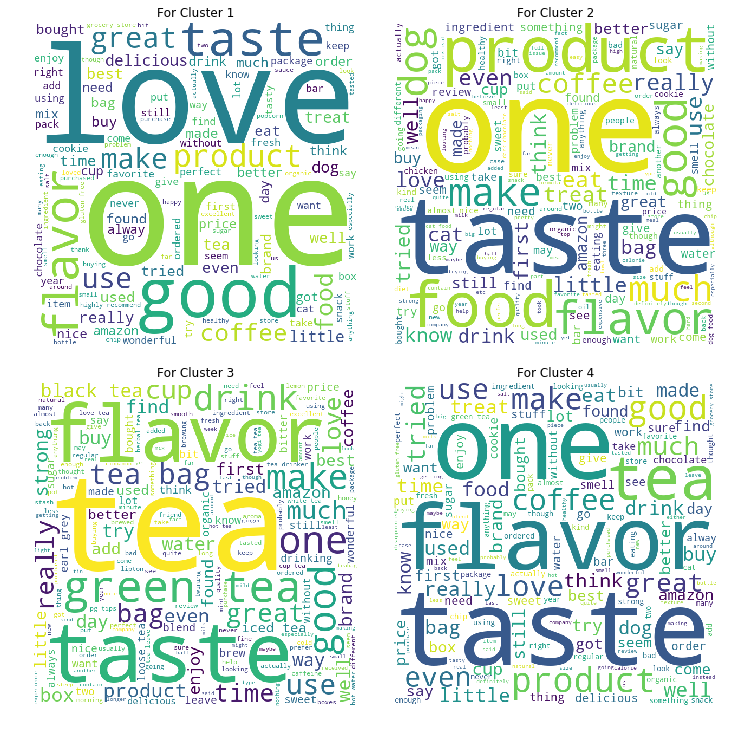

In [118]:
# plot the WordCloud image
fig = plt.figure(figsize=(10,10),facecolor=None)

# Plotting for cluster1
plt.subplot(2,2,1)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(2,2,2)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(2,2,3)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

# Plotting for cluster4
plt.subplot(2,2,4)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("For Cluster 4")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>First cluster mainly contains words like love ,one ,good , taste etc. This cluster mainly contains reviews which talks about how good the product is as there are words liks good, love , taste etc.</h4>
<h4>Second cluster contains words such as one ,taste ,food ,product and animal food as there is a word dog. There are words like coffee and drinks.</h4>
<h4>Third cluster contains words like tea , green tea ,flavour ,drink ,cup ,black tea ,taste. So by these words we can conclude that the reviews in this cluster mainly talks about tea and drinks.</h4>
<h4>Fourth cluster contains words flavour ,taste ,one ,tea ,coffee ,love ,good ,think great. We can say that this cluster contains reviews that talks about tea ,coffee and products with good flavour.</h4>

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [119]:
# Initializing count vect
tfidf_vect = TfidfVectorizer(min_df=5) #in scikit-learn
tfidf_data = tfidf_vect.fit_transform(preprocessed_reviews)
tfidf_data.shape

(46071, 12157)

In [120]:
inertia2 = [] # To measure squared distance of sample from nearest cluster distance.

for i in clusters:
    kmean2 = KMeans(n_clusters=i)
    kmean2 = kmean2.fit(tfidf_data)
    inertia2.append(kmean2.inertia_)

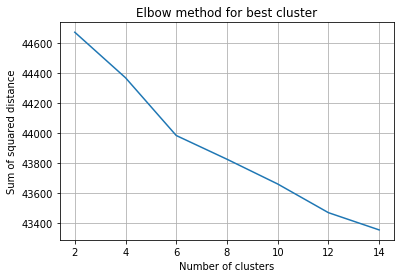

In [121]:
plt.plot(clusters,inertia2)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.grid()
plt.title("Elbow method for best cluster")
plt.show()

In [122]:
# Taking optimal k=6 as after that graph falls slowly
k=6
kmean = KMeans(n_clusters=k).fit(tfidf_data)
print(len(kmean.labels_))

46071


In [123]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
cluster1 = [] 
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

for i in range(len(kmean.labels_)):
    if(kmean.labels_[i]==0):
        cluster1.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==1):
        cluster2.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==2):
        cluster3.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==3):
        cluster4.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==4):
        cluster5.append(preprocessed_reviews[i])
    else:
        cluster6.append(preprocessed_reviews[i])

In [124]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(cluster1)))
print("Length of cluster {} is {}".format(2,len(cluster2)))
print("Length of cluster {} is {}".format(3,len(cluster3)))
print("Length of cluster {} is {}".format(4,len(cluster4)))
print("Length of cluster {} is {}".format(5,len(cluster5)))
print("Length of cluster {} is {}".format(6,len(cluster6)))

Length of cluster 1 is 3643
Length of cluster 2 is 1907
Length of cluster 3 is 5054
Length of cluster 4 is 21790
Length of cluster 5 is 10687
Length of cluster 6 is 2990


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [153]:
from wordcloud import WordCloud
def plot_wordcloud(reviews):
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(reviews) 
  
    return wordcloud

In [154]:
# Getting wordcloud for each cluster
# For cluster1
reviews1 = ''
for sent in cluster1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in cluster2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in cluster3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)

# For cluster4
reviews4 = ''
for sent in cluster4:
    wrds = sent.split()
    for wrd in wrds:
        reviews4 += wrd + ' '
wordcloud4 = plot_wordcloud(reviews4)

# For cluster5
reviews5 = ''
for sent in cluster5:
    wrds = sent.split()
    for wrd in wrds:
        reviews5 += wrd + ' '
wordcloud5 = plot_wordcloud(reviews5)

# For cluster6
reviews6 = ''
for sent in cluster6:
    wrds = sent.split()
    for wrd in wrds:
        reviews6 += wrd + ' '
wordcloud6 = plot_wordcloud(reviews6)

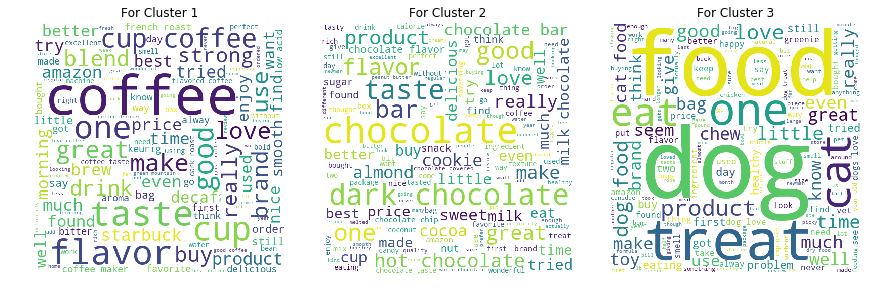

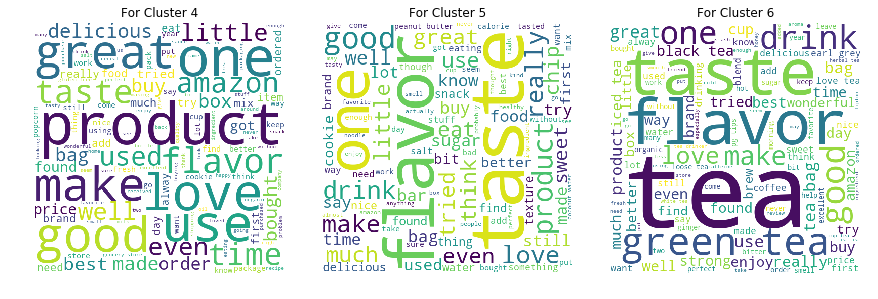

In [156]:
# plot the WordCloud image for each cluster
fig = plt.figure(figsize=(12,10),facecolor=None)

# Plotting for cluster1
plt.subplot(1,3,1)
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,3,2)
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(1,3,3)
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

plt.show()

fig = plt.figure(figsize=(12,10),facecolor=None)

# Plotting for cluster4
plt.subplot(1,3,1)
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("For Cluster 4")
plt.tight_layout(pad = 0) 

# Plotting for cluster5
plt.subplot(1,3,2)
plt.imshow(wordcloud5) 
plt.axis("off") 
plt.title("For Cluster 5")
plt.tight_layout(pad = 0) 

# Plotting for cluster4
plt.subplot(1,3,3)
plt.imshow(wordcloud6) 
plt.axis("off") 
plt.title("For Cluster 6")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains reviews of coffee as it has words such as coffee ,taste ,flavour ,cup.</h4>
<h4>Cluster 2 contains reviews which talks of dark chocalates , cookie etc.</h4>
<h4>Cluster 3 contains reviews which talks of pet foods as in contains words such as dog , cat ,food ,eat etc.</h4>
<h4>Cluster 4 mainly contains reviews about the product and whether the customers liked that  product or not as these clusters contains words like product , love ,great ,good ,order ,amazon ,bag etc.</h4>
<h4>Cluster 5 mainly contains reviews that talks about the foods flavour and taste as it contains words like flavour ,taste ,one ,sugar ,eat etc.</h4>
<h4>Cluster 6 contains reviews that talks about tea and its flavour as it contains wors like tea ,flavour ,green tea ,black tea,taste,drink etc. </h4>

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [157]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [158]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8408229947090149), ('fantastic', 0.8305901885032654), ('terrific', 0.8203120231628418), ('good', 0.8122492432594299), ('wonderful', 0.7979425191879272), ('amazing', 0.7702380418777466), ('perfect', 0.767071545124054), ('excellent', 0.7551702260971069), ('fabulous', 0.7207266092300415), ('decent', 0.6943749189376831)]
[('greatest', 0.7463002800941467), ('best', 0.7421388626098633), ('experienced', 0.6642546653747559), ('tastiest', 0.6566175818443298), ('closest', 0.6549221873283386), ('ive', 0.6447591781616211), ('nastiest', 0.6369874477386475), ('healthiest', 0.6330172419548035), ('awful', 0.6300492286682129), ('hottest', 0.6275832056999207)]


In [160]:
w2v_words = list(w2v_model.wv.vocab)

In [161]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

46071
50


In [162]:
inertia3 = [] # To measure squared distance of sample from nearest cluster distance.
for i in clusters:
    kmean3 = KMeans(n_clusters=i)
    kmean3 = kmean3.fit(sent_vectors)
    inertia3.append(kmean3.inertia_)

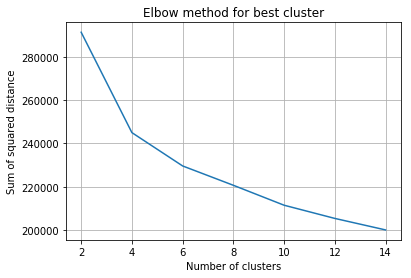

In [164]:
plt.plot(clusters,inertia3)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.grid()
plt.title("Elbow method for best cluster")
plt.show()

In [165]:
# Taking optimal k=6 as after that graph falls slowly
k=4
kmean = KMeans(n_clusters=k).fit(tfidf_data)
print(len(kmean.labels_))

46071


In [166]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
cluster1 = [] 
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(len(kmean.labels_)):
    if(kmean.labels_[i]==0):
        cluster1.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==1):
        cluster2.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==2):
        cluster3.append(preprocessed_reviews[i])
    else:
        cluster4.append(preprocessed_reviews[i])

In [167]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(cluster1)))
print("Length of cluster {} is {}".format(2,len(cluster2)))
print("Length of cluster {} is {}".format(3,len(cluster3)))
print("Length of cluster {} is {}".format(4,len(cluster4)))

Length of cluster 1 is 3778
Length of cluster 2 is 13827
Length of cluster 3 is 5304
Length of cluster 4 is 23162


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [56]:
from wordcloud import WordCloud
def plot_wordcloud(reviews):
    wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                min_font_size = 10).generate(reviews) 
  
    return wordcloud

In [169]:
# For cluster1
reviews1 = ''
for sent in cluster1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in cluster2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in cluster3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)

# For cluster4
reviews4 = ''
for sent in cluster4:
    wrds = sent.split()
    for wrd in wrds:
        reviews4 += wrd + ' '
wordcloud4 = plot_wordcloud(reviews4)

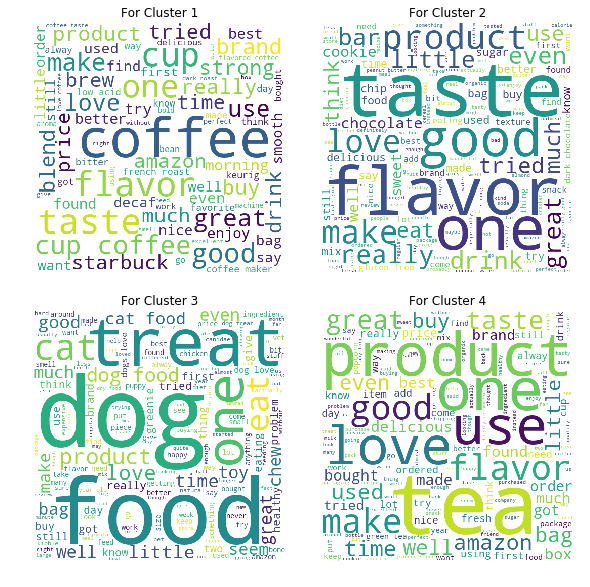

In [170]:
# plot the WordCloud image
fig = plt.figure(figsize=(8,8),facecolor=None)

# Plotting for cluster1
plt.subplot(2,2,1)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(2,2,2)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(2,2,3)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

# Plotting for cluster4
plt.subplot(2,2,4)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("For Cluster 4")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains reviews of coffee as it contains words such as coffee ,cup ,starbuck ,brew etc.</h4>
<h4>Cluster 2 contains reviews that talks of flavour and taste of food items and how good the taste is.</h4>
<h4>Cluster 3 contains reviews of pet foods as it contains words sucg as dog ,cat ,food etc.</h4>
<h4>Cluster 4 talks about tea as it contains words such as tea ,lobe ,flavour ,product ,good etc.</h4>

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [171]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [172]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [175]:
inertia4 = [] # To measure squared distance of sample from nearest cluster distance.

for i in clusters:
    kmean4 = KMeans(n_clusters=i)
    kmean4 = kmean4.fit(tfidf_sent_vectors)
    inertia4.append(kmean4.inertia_)

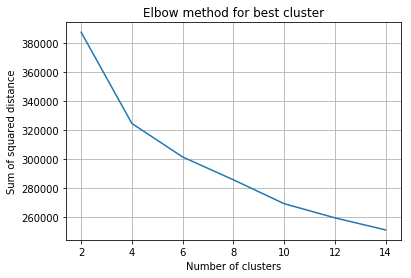

In [176]:
plt.plot(clusters,inertia4)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distance")
plt.grid()
plt.title("Elbow method for best cluster")
plt.show()

In [178]:
# Taking optimal k=6 as after that graph falls slowly
k=4
kmean = KMeans(n_clusters=k).fit(tfidf_sent_vectors)
print(len(kmean.labels_))

46071


In [179]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
cluster1 = [] 
cluster2 = []
cluster3 = []
cluster4 = []

for i in range(len(kmean.labels_)):
    if(kmean.labels_[i]==0):
        cluster1.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==1):
        cluster2.append(preprocessed_reviews[i])
    elif(kmean.labels_[i]==2):
        cluster3.append(preprocessed_reviews[i])
    else:
        cluster4.append(preprocessed_reviews[i])

In [180]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(cluster1)))
print("Length of cluster {} is {}".format(2,len(cluster2)))
print("Length of cluster {} is {}".format(3,len(cluster3)))
print("Length of cluster {} is {}".format(4,len(cluster4)))

Length of cluster 1 is 17867
Length of cluster 2 is 15164
Length of cluster 3 is 6221
Length of cluster 4 is 6819


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [181]:
# For cluster1
reviews1 = ''
for sent in cluster1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in cluster2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in cluster3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)

# For cluster4
reviews4 = ''
for sent in cluster4:
    wrds = sent.split()
    for wrd in wrds:
        reviews4 += wrd + ' '
wordcloud4 = plot_wordcloud(reviews4)

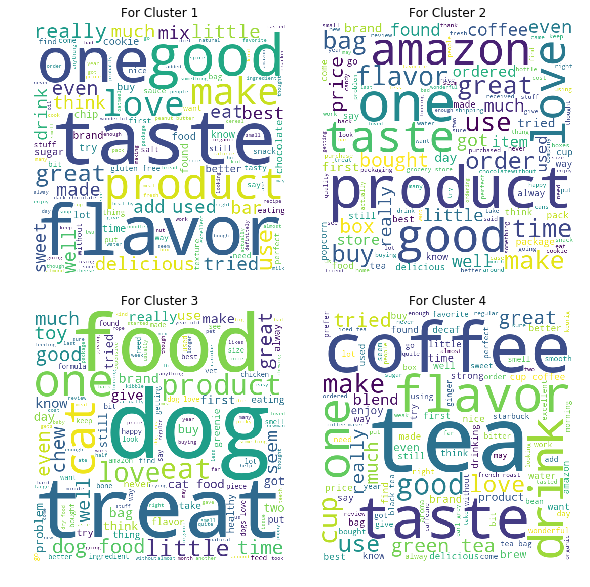

In [182]:
# plot the WordCloud image
fig = plt.figure(figsize=(8,8),facecolor=None)

# Plotting for cluster1
plt.subplot(2,2,1)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(2,2,2)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(2,2,3)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

# Plotting for cluster4
plt.subplot(2,2,4)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("For Cluster 4")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains words flavour ,taste ,good. Contains reviews of flavour and taste od food.</h4>
<h4>Cluster 2 contains words product .amazon .good ,taste. Contains reviews of procducts and price and its quality on amazon.</h4>
<h4>Cluster 3 contains reviews of pet foods as it cotains words such as dog , cat ,food ,treat.</h4>
<h4>Cluster 4 contains reviews of hot drinks such as tea and coffee as it contains words such as tea ,coffee.</h4>

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [39]:
# We will take 5k points for this
agglo_df = final.sample(10000)
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in agglo_df['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [40]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [41]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8555106520652771), ('excellent', 0.8533652424812317), ('makes', 0.8020756244659424), ('quick', 0.7937959432601929), ('easy', 0.7759731411933899), ('amazing', 0.752975344657898), ('value', 0.7490496635437012), ('overall', 0.7378822565078735), ('works', 0.7290659546852112), ('super', 0.7257925868034363)]
[('hands', 0.9804447889328003), ('decades', 0.9803352355957031), ('jet', 0.9794924855232239), ('absolute', 0.9786662459373474), ('hooked', 0.9752174615859985), ('plums', 0.9733247756958008), ('particular', 0.9731670022010803), ('admit', 0.972885251045227), ('world', 0.9728695750236511), ('curiosity', 0.9721816182136536)]


In [42]:
w2v_words = list(w2v_model.wv.vocab)

In [43]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 10000/10000 [00:29<00:00, 340.07it/s]

10000
50


<h3>Agglomerative clustering with n_clusters = 2</h3>

In [44]:
# Performing agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

agc = AgglomerativeClustering(n_clusters=2).fit(sent_vectors)
print(len(agc.labels_))

10000


In [46]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
cluster1 = [] 
cluster2 = []

for i in range(len(agc.labels_)):
    if(agc.labels_[i]==0):
        cluster1.append(preprocessed_reviews[i])
    else:
        cluster2.append(preprocessed_reviews[i])

In [47]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(cluster1)))
print("Length of cluster {} is {}".format(2,len(cluster2)))

Length of cluster 1 is 6664
Length of cluster 2 is 3336


<h3>Agglomerative clustering with n_clusters = 3</h3>

In [48]:
agc = AgglomerativeClustering(n_clusters=3).fit(sent_vectors)
print(len(agc.labels_))

10000


In [50]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
clstr1 = [] 
clstr2 = []
clstr3 = []

for i in range(len(agc.labels_)):
    if(agc.labels_[i]==0):
        clstr1.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==1):
        clstr2.append(preprocessed_reviews[i])
    else:
        clstr3.append(preprocessed_reviews[i])

In [51]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(clstr1)))
print("Length of cluster {} is {}".format(2,len(clstr2)))
print("Length of cluster {} is {}".format(3,len(clstr3)))

Length of cluster 1 is 3336
Length of cluster 2 is 4889
Length of cluster 3 is 1775


<h3>Agglomerative clustering with n_clusters = 5</h3>

In [52]:
agc = AgglomerativeClustering(n_clusters=5).fit(sent_vectors)
print(len(agc.labels_))

10000


In [53]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
clustr1 = [] 
clustr2 = []
clustr3 = []
clustr4 = []
clustr5 = []

for i in range(len(agc.labels_)):
    if(agc.labels_[i]==0):
        clustr1.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==1):
        clustr2.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==2):
        clustr3.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==3):
        clustr4.append(preprocessed_reviews[i])
    else:
        clustr5.append(preprocessed_reviews[i])

In [54]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(clustr1)))
print("Length of cluster {} is {}".format(2,len(clustr2)))
print("Length of cluster {} is {}".format(3,len(clustr3)))
print("Length of cluster {} is {}".format(4,len(clustr4)))
print("Length of cluster {} is {}".format(5,len(clustr5)))

Length of cluster 1 is 1775
Length of cluster 2 is 2230
Length of cluster 3 is 3936
Length of cluster 4 is 1106
Length of cluster 5 is 953


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

<h3>Agglomerative clustering with n_clusters = 2</h3>

In [57]:
# For cluster1
reviews1 = ''
for sent in cluster1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in cluster2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)


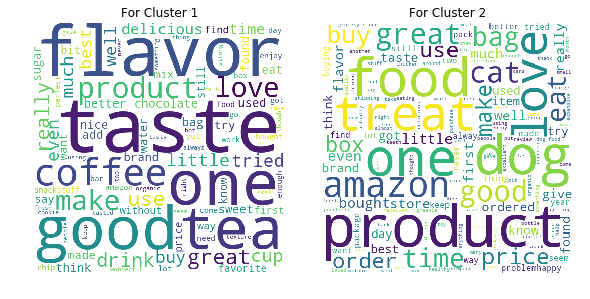

In [58]:
# plot the WordCloud image
fig = plt.figure(figsize=(8,8),facecolor=None)

# Plotting for cluster1
plt.subplot(1,2,1)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,2,2)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains reviews of coffee ,tea and taste and flavour of food items as it contains words such as taste ,coffee ,tea ,good ,flavour .</h4>
<h4>Cluster 2 contains reviews of product on amazon and of pet foods  as it contains words such as product ,amazon ,dog ,cat.</h4>

<h3>Agglomerative clustering with n_clusters = 3</h3>

In [59]:
# For cluster1
reviews1 = ''
for sent in clstr1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in clstr2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in clstr3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)


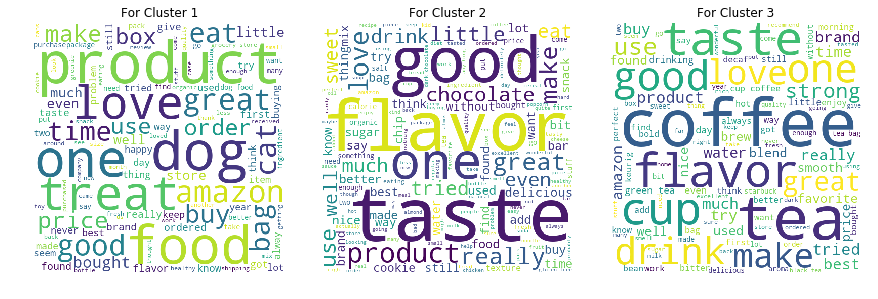

In [61]:
# plot the WordCloud image
fig = plt.figure(figsize=(12,12),facecolor=None)

# Plotting for cluster1
plt.subplot(1,3,1)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,3,2)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(1,3,3)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains reviews on products on amazon and pet food and also on price of products as it contains words such as product ,dog ,food ,amazon ,price ,box.</h4>
<h4>Cluster 2 contains reviews on flavour ,taste of chocolate and drinks.</h4>
<h4>Cluster 3 contains reviews on coffee ,tea and its flavour and taste.</h4>

<h3>Agglomerative clustering with n_clusters = 5</h3>

In [62]:
# For cluster1
reviews1 = ''
for sent in clustr1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in clustr2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in clustr3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)

# For cluster3
reviews4 = ''
for sent in clustr4:
    wrds = sent.split()
    for wrd in wrds:
        reviews4 += wrd + ' '
wordcloud4 = plot_wordcloud(reviews4)

# For cluster3
reviews5 = ''
for sent in clustr5:
    wrds = sent.split()
    for wrd in wrds:
        reviews5 += wrd + ' '
wordcloud5 = plot_wordcloud(reviews5)

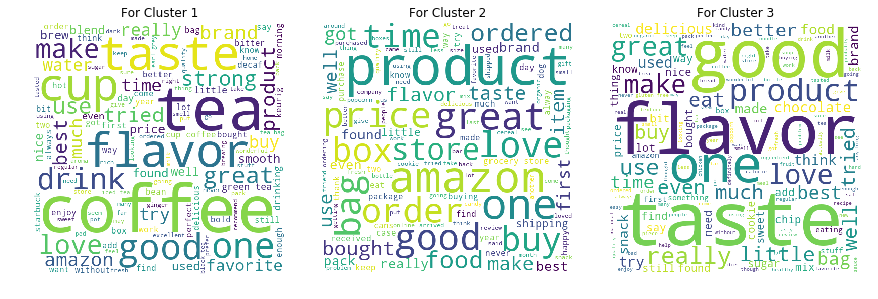

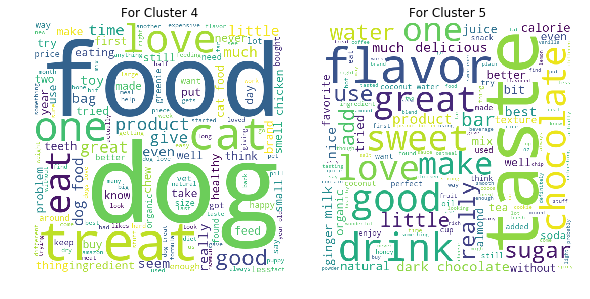

In [65]:
# plot the WordCloud image
fig = plt.figure(figsize=(12,12),facecolor=None)

# Plotting for cluster1
plt.subplot(1,3,1)
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,3,2)
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(1,3,3)
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

plt.show() 

fig = plt.figure(figsize=(8,8),facecolor=None)

# Plotting for cluster1
plt.subplot(1,2,1)
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("For Cluster 4")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,2,2)
plt.imshow(wordcloud5) 
plt.axis("off") 
plt.title("For Cluster 5")
plt.tight_layout(pad = 0) 
plt.show()

<h3>Observations<h3>
<h4>Cluster 1 contains reviews on coffee ,tea and its flavour and taste.</h4>
<h4>Cluster 2 contains reviews on products on amazon and also on price of products as it contains words such as product ,food ,amazon ,price ,box.</h4>  
<h4>Cluster 3 contains reviews on flavour ,taste of various foods.<h4>
<h4>Cluster 4 contains reviews on pet foods .</h4>
<h4>Cluster 5 contains reviews on taste and flavour of chocalate and drinks.</h4>

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [66]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [67]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [02:10<00:00, 76.91it/s]


<h3>Agglomerative clustering with n_clusters = 2</h3>

In [68]:
# Performing agglomerative clustering
from sklearn.cluster import AgglomerativeClustering

agc = AgglomerativeClustering(n_clusters=2).fit(tfidf_sent_vectors)
print(len(agc.labels_))

10000


In [69]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
cluster1 = [] 
cluster2 = []

for i in range(len(agc.labels_)):
    if(agc.labels_[i]==0):
        cluster1.append(preprocessed_reviews[i])
    else:
        cluster2.append(preprocessed_reviews[i])

In [70]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(cluster1)))
print("Length of cluster {} is {}".format(2,len(cluster2)))

Length of cluster 1 is 4818
Length of cluster 2 is 5182


<h3>Agglomerative clustering with n_clusters=3</h3>

In [71]:
agc = AgglomerativeClustering(n_clusters=3).fit(tfidf_sent_vectors)
print(len(agc.labels_))

10000


In [72]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
clstr1 = [] 
clstr2 = []
clstr3 = []

for i in range(len(agc.labels_)):
    if(agc.labels_[i]==0):
        clstr1.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==1):
        clstr2.append(preprocessed_reviews[i])
    else:
        clstr3.append(preprocessed_reviews[i])

In [73]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(clstr1)))
print("Length of cluster {} is {}".format(2,len(clstr2)))
print("Length of cluster {} is {}".format(3,len(clstr3)))

Length of cluster 1 is 5182
Length of cluster 2 is 1507
Length of cluster 3 is 3311


<h3>Agglomerative Clustering with n_clusters = 5</h3>

In [74]:
agc = AgglomerativeClustering(n_clusters=5).fit(tfidf_sent_vectors)
print(len(agc.labels_))

10000


In [75]:
# Now seperating datapoints according to their cluster id

# Points with cluster i will be saved in (i+1) cluster as cluster labels starts from 0 and we have numbered cluster from 1.
clustr1 = [] 
clustr2 = []
clustr3 = []
clustr4 = []
clustr5 = []

for i in range(len(agc.labels_)):
    if(agc.labels_[i]==0):
        clustr1.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==1):
        clustr2.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==2):
        clustr3.append(preprocessed_reviews[i])
    elif(agc.labels_[i]==3):
        clustr4.append(preprocessed_reviews[i])
    else:
        clustr5.append(preprocessed_reviews[i])

In [76]:
# Printing size of each cluster
print("Length of cluster {} is {}".format(1,len(clustr1)))
print("Length of cluster {} is {}".format(2,len(clustr2)))
print("Length of cluster {} is {}".format(3,len(clustr3)))
print("Length of cluster {} is {}".format(4,len(clustr4)))
print("Length of cluster {} is {}".format(5,len(clustr5)))

Length of cluster 1 is 1507
Length of cluster 2 is 2427
Length of cluster 3 is 3311
Length of cluster 4 is 962
Length of cluster 5 is 1793


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

<h3>Wordcloud for n_clusters = 2</h3>

In [77]:
# For cluster1
reviews1 = ''
for sent in cluster1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in cluster2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

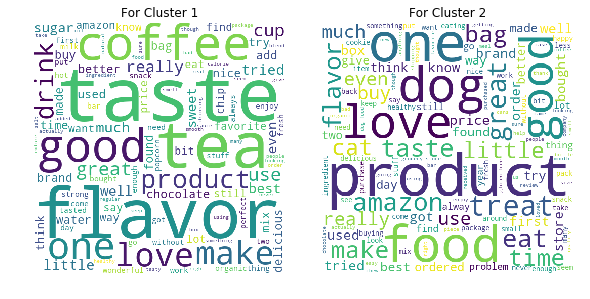

In [78]:
# plot the WordCloud image
fig = plt.figure(figsize=(8,8),facecolor=None)

# Plotting for cluster1
plt.subplot(1,2,1)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,2,2)
#plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains reviews of coffee ,tea and taste and flavour of food items as it contains words such as taste ,coffee ,tea ,good ,flavour .</h4>
<h4>Cluster 2 contains reviews of product on amazon and of pet foods  as it contains words such as product ,amazon ,dog ,cat.</h4>

<h3>Word Cloud for n_clusters = 3</h3>

In [79]:
# For cluster1
reviews1 = ''
for sent in clstr1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in clstr2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in clstr3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)

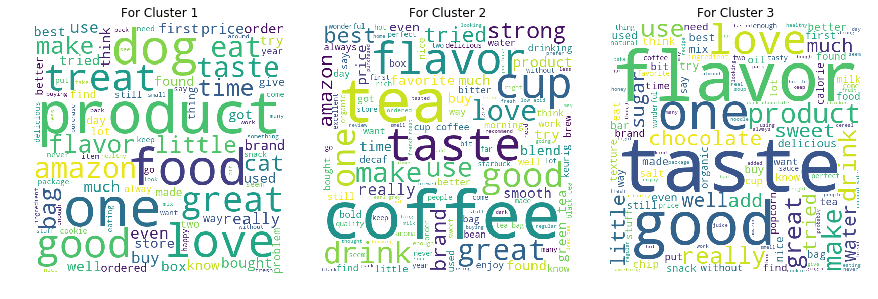

In [81]:
# plot the WordCloud image
fig = plt.figure(figsize=(12,12),facecolor=None)

# Plotting for cluster1
plt.subplot(1,3,1)
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,3,2)
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(1,3,3)
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains reviews on products on amazon and pet food and also on price of products as it contains words such as product ,dog ,food ,amazon ,price ,box.</h4>
<h4>Cluster 2 contains reviews on coffee ,tea and its flavour and taste.</h4>
<h4>Cluster 3 contains reviews on flavour ,taste of chocolate and drinks.</h4>

<h3>Word cloud for n_clusters=5</h3>

In [82]:
# For cluster1
reviews1 = ''
for sent in clustr1:
    wrds = sent.split()
    for wrd in wrds:
        reviews1 += wrd + ' '
wordcloud1 = plot_wordcloud(reviews1)


# For cluster2
reviews2 = ''
for sent in clustr2:
    wrds = sent.split()
    for wrd in wrds:
        reviews2 += wrd + ' '
wordcloud2 = plot_wordcloud(reviews2)

# For cluster3
reviews3 = ''
for sent in clustr3:
    wrds = sent.split()
    for wrd in wrds:
        reviews3 += wrd + ' '
wordcloud3 = plot_wordcloud(reviews3)

# For cluster3
reviews4 = ''
for sent in clustr4:
    wrds = sent.split()
    for wrd in wrds:
        reviews4 += wrd + ' '
wordcloud4 = plot_wordcloud(reviews4)

# For cluster3
reviews5 = ''
for sent in clustr5:
    wrds = sent.split()
    for wrd in wrds:
        reviews5 += wrd + ' '
wordcloud5 = plot_wordcloud(reviews5)

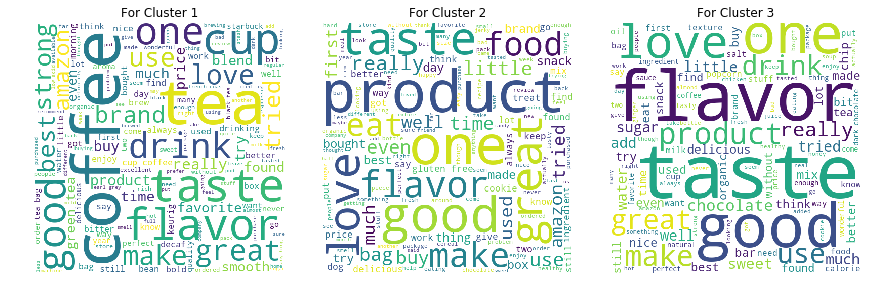

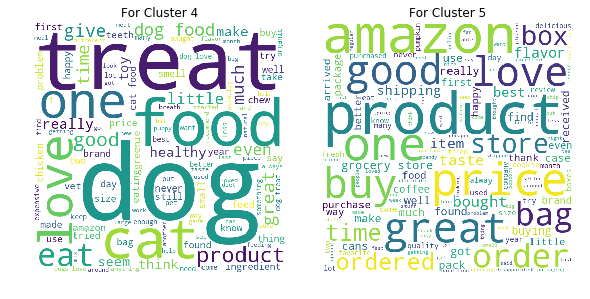

In [83]:
# plot the WordCloud image
fig = plt.figure(figsize=(12,12),facecolor=None)

# Plotting for cluster1
plt.subplot(1,3,1)
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.title("For Cluster 1")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,3,2)
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.title("For Cluster 2")
plt.tight_layout(pad = 0) 

# Plotting for cluster3
plt.subplot(1,3,3)
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.title("For Cluster 3")
plt.tight_layout(pad = 0) 

plt.show() 

fig = plt.figure(figsize=(8,8),facecolor=None)

# Plotting for cluster1
plt.subplot(1,2,1)
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.title("For Cluster 4")
plt.tight_layout(pad = 0) 

# Plotting for cluster2
plt.subplot(1,2,2)
plt.imshow(wordcloud5) 
plt.axis("off") 
plt.title("For Cluster 5")
plt.tight_layout(pad = 0) 
plt.show()

<h3>Observations<h3>
<h4>Cluster 1 contains reviews on coffee ,tea and its flavour and taste.</h4>
<h4>Cluster 2 contains reviews on products on amazon and also on price of products as it contains words such as product ,food ,amazon ,price ,box.</h4>  
<h4>Cluster 3 contains reviews on flavour ,taste of various foods.<h4>
<h4>Cluster 4 contains reviews on pet foods .</h4>
<h4>Cluster 5 contains reviews on taste and flavour of chocalate and drinks.</h4>

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [84]:
# First we will calculate the outliers

def plot_elbow(data,min_pnts):
    min_pnts_distance = []
    for d in tqdm(data):
        dist = np.linalg.norm(data-d,axis=1) # Will calculate l2 norm i.e. eculidian distance between points.
        # Now we will sort these distances in ascending order
        # Distance at index min_pnts in the ssorted arry is our min_pnts's distance from xi.
        # we will append this distance to min_pnts_distance
        temp_dist = np.sort(dist) 
        min_pnts_distance.append(temp_dist[min_pnts])
        
    # Now we will plot elbow curve to find outliers.
    # In this we will first sort min_pnts_distance.
    sorted_distance = np.sort(min_pnts_distance)
    plt.plot(sorted_distance)
    plt.grid()
    plt.xlabel("Index of points")
    plt.ylabel("nth nearest distance")
    plt.title("Elbow curve to determine best eps")
    plt.show()

100%|██████████| 10000/10000 [01:02<00:00, 161.24it/s]


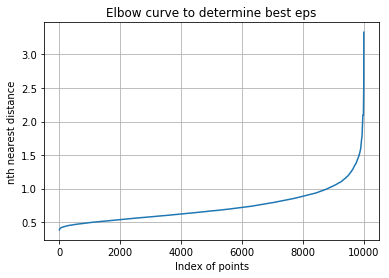

In [87]:
# sent vectors contains avg_w2v vectorized datapoints
plot_elbow(sent_vectors,2*len(sent_vectors[0]))

In [ ]:
# observing the graph we can see that the distance is suddenly increasing 
# Best eps between 0.9 to 1.5

In [94]:
# AS a rule of thumb we take min_pnts = 2 * dimensionality of datapoints
# Now we will plot the curve for various eps
from sklearn.cluster import DBSCAN

print("For eps {}".format(0.9))
dbscan =  DBSCAN(eps = 0.9,min_samples = 2*len(sent_vectors[0])).fit(sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster1 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster1[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))
    

For eps 0.9
Number of clusters 2


In [96]:
# For eps = 1.1
print("For eps {}".format(1.1))
dbscan =  DBSCAN(eps = 1.1,min_samples = 2*len(sent_vectors[0])).fit(sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster2 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster2[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))
    

For eps 1.1
Number of clusters 2


In [97]:
# For eps = 1.3
print("For eps {}".format(1.3))
dbscan =  DBSCAN(eps = 1.3,min_samples = 2*len(sent_vectors[0])).fit(sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster3 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster3[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))

For eps 1.3
Number of clusters 2


In [98]:
# For eps = 1.5
print("For eps {}".format(1.5))
dbscan =  DBSCAN(eps = 1.5,min_samples = 2*len(sent_vectors[0])).fit(sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster4 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster4[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))

For eps 1.5
Number of clusters 2


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

Wordcloud for clusters when eps=0.9
For cluster 1


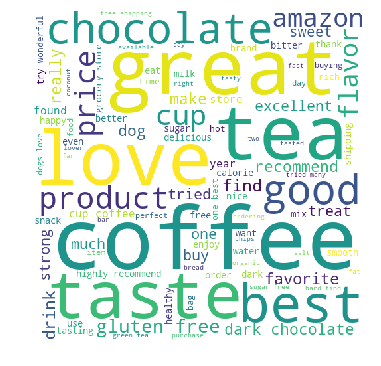

For cluster 2


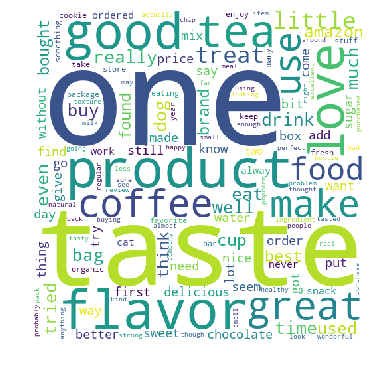

In [102]:
# For eps = 0.9
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps=0.9")
for i in range(len(cluster1)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster1[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together.</h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love .</h4>

Wordcloud for clusters when eps = 1.1
For cluster 1


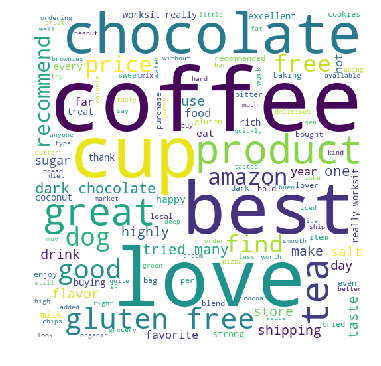

For cluster 2


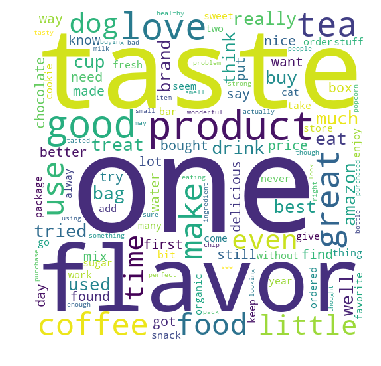

In [103]:
# For eps = 1.1
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps = 1.1")
for i in range(len(cluster2)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster2[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together and surprisingly reviews on coffee and chocolate have been clustered with outlier points.</h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love ,food ,good .</h4>

Wordcloud for clusters when eps = 1.3
For cluster 1


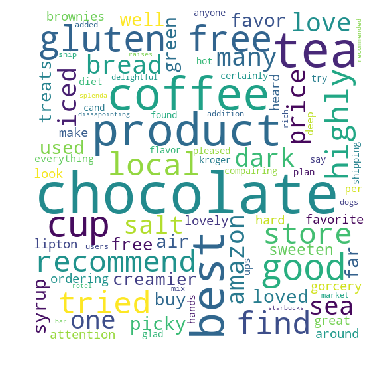

For cluster 2


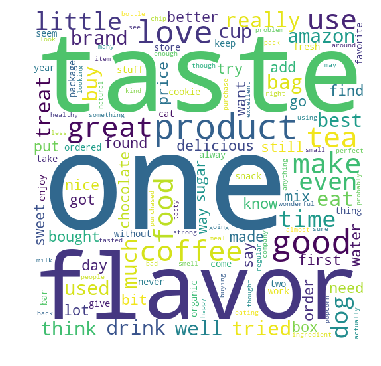

In [104]:
# For eps = 1.3
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps = 1.3")
for i in range(len(cluster3)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster3[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together </h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love  ,good ,drink.</h4>

Wordcloud for clusters when eps = 1.5
For cluster 1


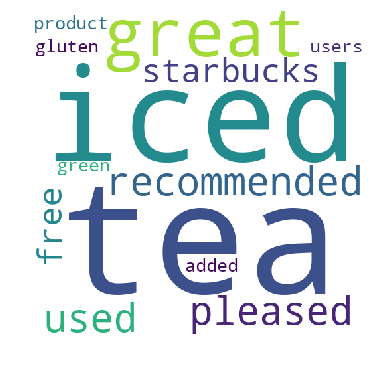

For cluster 2


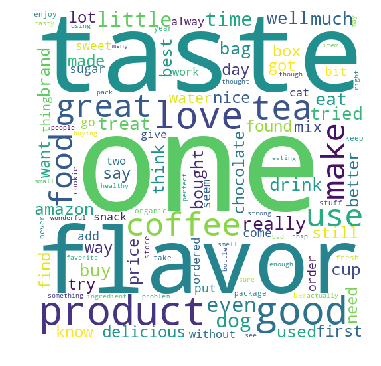

In [105]:
# For eps = 1.5
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps = 1.5")
for i in range(len(cluster4)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster4[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together and very few datapoints are present in noisy cluster.</h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love .</h4>

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 10000/10000 [01:00<00:00, 164.07it/s]


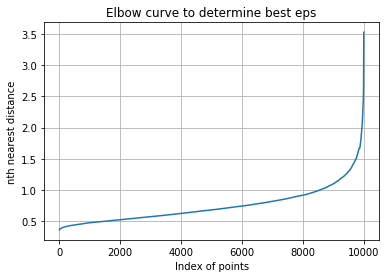

In [109]:
# Plotting elbow graph for tfidf w2v
# tfidf_sent_vectors contains avg_w2v vectorized datapoints
plot_elbow(tfidf_sent_vectors,2*len(tfidf_sent_vectors[0]))

In [ ]:
# we will take eps values from 0.9 to 1.5

In [110]:
# AS a rule of thumb we take min_pnts = 2 * dimensionality of datapoints
# Now we will plot the curve for various eps
from sklearn.cluster import DBSCAN

print("For eps {}".format(0.9))
dbscan =  DBSCAN(eps = 0.9,min_samples = 2*len(tfidf_sent_vectors[0])).fit(tfidf_sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster1 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster1[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))
    

For eps 0.9
Number of clusters 2


In [111]:
# AS a rule of thumb we take min_pnts = 2 * dimensionality of datapoints
# Now we will plot the curve for various eps
from sklearn.cluster import DBSCAN

print("For eps {}".format(1.1))
dbscan =  DBSCAN(eps = 1.1,min_samples = 2*len(tfidf_sent_vectors[0])).fit(tfidf_sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster2 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster2[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))
    

For eps 1.1
Number of clusters 2


In [112]:
# AS a rule of thumb we take min_pnts = 2 * dimensionality of datapoints
# Now we will plot the curve for various eps
from sklearn.cluster import DBSCAN

print("For eps {}".format(1.3))
dbscan =  DBSCAN(eps = 1.3,min_samples = 2*len(tfidf_sent_vectors[0])).fit(tfidf_sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster3 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster3[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))
    

For eps 1.3
Number of clusters 2


In [113]:
# AS a rule of thumb we take min_pnts = 2 * dimensionality of datapoints
# Now we will plot the curve for various eps
from sklearn.cluster import DBSCAN

print("For eps {}".format(1.5))
dbscan =  DBSCAN(eps = 1.5,min_samples = 2*len(tfidf_sent_vectors[0])).fit(tfidf_sent_vectors)

# getting number of labels
# 1 is added because dbscan gives a cluster label of -1 to the noisy points.
# Hence now cluster with label id 0 contains outliers.
labels = dbscan.labels_ +1 
labels_len = len(set(dbscan.labels_)) 
    
# Creating a list which contains number of lists which is equal to  number of clusters.
cluster4 = [[] for i in range(labels_len)]
    
for i in range(len(dbscan.labels_)): 
    # dbscan.labels[i] gives the cluster id and hence we append xi to that cluster
    cluster4[labels[i]].append(preprocessed_reviews[i]) # Append reviews to their cluster .

print("Number of clusters {}".format(labels_len))

For eps 1.5
Number of clusters 2


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

Wordcloud for clusters when eps=0.9
For cluster 1


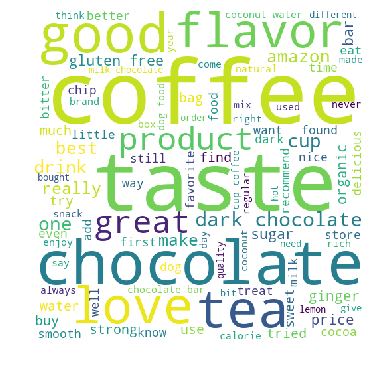

For cluster 2


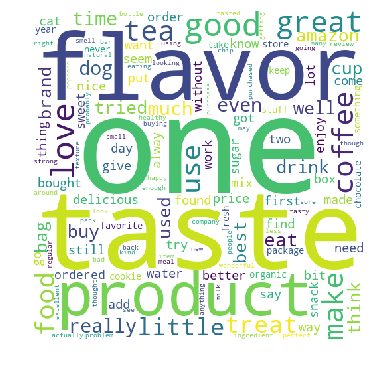

In [114]:
# For eps = 0.9
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps=0.9")
for i in range(len(cluster1)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster1[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together with reviews on coffee and chocalete and tea also put in noisy  pounts.</h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love .</h4>

Wordcloud for clusters when eps = 1.1
For cluster 1


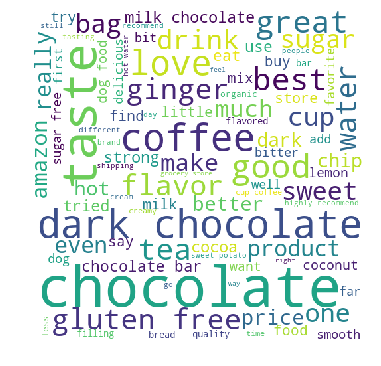

For cluster 2


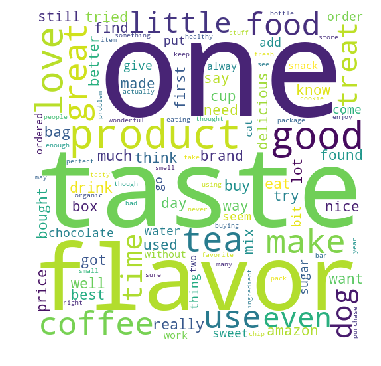

In [115]:
# For eps = 1.1
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps = 1.1")
for i in range(len(cluster2)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster2[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together with reviews on coffee and chocalete and tea also put in noisy  pounts.</h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love .</h4>

Wordcloud for clusters when eps = 1.3
For cluster 1


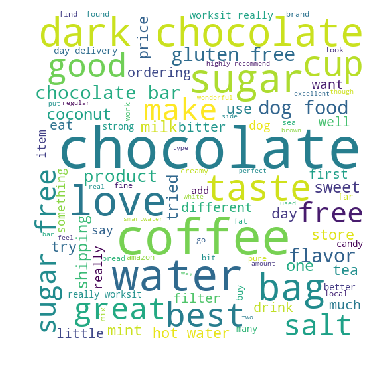

For cluster 2


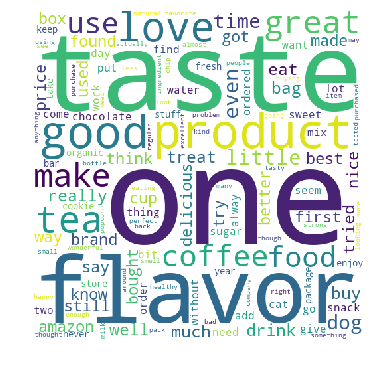

In [116]:
# For eps = 1.3
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps = 1.3")
for i in range(len(cluster3)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster3[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together with reviews on coffee and chocalete and tea also put in noisy  pounts.</h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love .</h4>

Wordcloud for clusters when eps = 1.5
For cluster 1


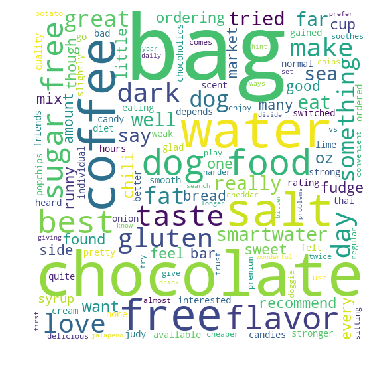

For cluster 2


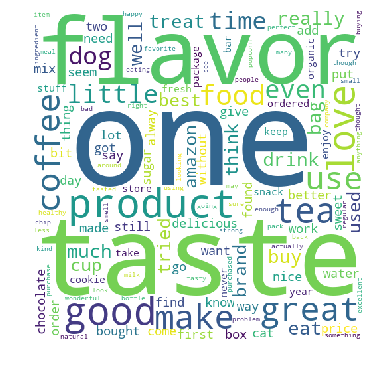

In [117]:
# For eps = 1.5
# Plotting Word Cloud for clusters.
print("Wordcloud for clusters when eps = 1.5")
for i in range(len(cluster4)): # Will iterate through each cluster
    # creating a text from all the reviews of a cluster
    print("For cluster {}".format(i+1))
    reviews = ''
    for sent in cluster4[i]:
        for wrd in sent.split():
            reviews += wrd + ' '
        
    # getting wordcloud for the cluster
    wordcloud = plot_wordcloud(reviews)
        
    # Plotting the wordcloud
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show() 

<h3>Observations</h3>
<h4>Cluster 1 contains all the noisy datapoints together with reviews on coffee and chocalete and tea also put in noisy  pounts.</h4>
<h4>Cluster 2 contains words like taste ,one ,product ,coffee ,flavour ,great ,tea ,love .</h4>

# [6] Conclusions

In [122]:
from prettytable import PrettyTable
print("For K-means Clustering")
x = PrettyTable()
x.field_names = ['Vectorizer','best no. of clusters']
x.add_row(['Bow','4'])
x.add_row(['Tfidf','6'])
x.add_row(['AvgW2V','4'])
x.add_row(['Tfidf W2V','4'])
print(x)

print("\n")
print("="*50)
print("\n")

print("For Agglomerative Clustering")
x = PrettyTable()
x.field_names = ['Vectorizer','best no. of clusters']
x.add_row(['AvgW2V','3'])
x.add_row(['Tfidf W2V','3'])
print(x)

print("\n")
print("="*50)
print("\n")

print("For DBSCAN Clustering")
x = PrettyTable()
x.field_names = ['Vectorizer','best eps']
x.add_row(['AvgW2V','1.5'])
x.add_row(['Tfidf W2V','1.4'])
print(x)

For K-means Clustering
+------------+----------------------+
| Vectorizer | best no. of clusters |
+------------+----------------------+
|    Bow     |          4           |
|   Tfidf    |          6           |
|   AvgW2V   |          4           |
| Tfidf W2V  |          4           |
+------------+----------------------+




For Agglomerative Clustering
+------------+----------------------+
| Vectorizer | best no. of clusters |
+------------+----------------------+
|   AvgW2V   |          3           |
| Tfidf W2V  |          3           |
+------------+----------------------+




For DBSCAN Clustering
+------------+----------+
| Vectorizer | best eps |
+------------+----------+
|   AvgW2V   |   1.5    |
| Tfidf W2V  |   1.4    |
+------------+----------+


<h1>Explaination</h1>
<h4>We have used 50k datapoints for k-means clustering.</h4>
<h4>We have used elbow method to find the best k for k-means by plotting k vs inertia plot.</h4>
<h4>The best cluster happened using K-means on Tfidf which gave 6 clusters each for reviews on coffee reviews , tea reviews ,chocolate reviews ,pet foods reviews , flavour & taste of foods reviews and products & price on amazon reviews.</h4>
<h4>We have used 10k points for Agglomerative and DBSCAN clustering.</h4>
<h4>The best clustering for agglomerative was with n_clusters = 3 . In this we got three clusters each for pet foods reviews,tea & cofee reviews and flavour & taste of foods reviews</h4>
<h4>Agglomerative had same performance on both AvgW2V and Tfidf W2V vectorized datapoints.</h4>
<h4>For DBSCAN we used elbow method to find best eps . To do this we plotted indices of points on x axis and distance to nearest min_point neighbor and selected that distance where graph suddenly changed.</h4>
<h4>The best eps that we got using thid was 1.5</h4>
<h4>DBSCAN performed best on AvgW2V where in the outlier cluster we had very few datapoints.</h4>
<h4>Hence overall out best model was K-means cluster with 6 clusters and clustering done on tfidf vectorized datapoints.</h4>